# 1. Install Dependencies and Setup

In [ ]:
pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
anyio                        3.7.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blis                         0.7.9
cachetools                   5.3.0
catalogue                    2.0.8
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.1.0
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confection                   0.0.4
contourpy                    1.0.7
cycler                       0.11.0
cymem                        2.0.7
debugpy                      1.6.7
decorator                    5.1.1
defu

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12932\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [147]:
data_dir = 'data2' 

In [148]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [149]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [129]:
import numpy as np
from matplotlib import pyplot as plt

In [146]:
data = tf.keras.utils.image_dataset_from_directory('data2')

Found 470 files belonging to 2 classes.


In [150]:
data_iterator = data.as_numpy_iterator()

In [151]:
batch = data_iterator.next()

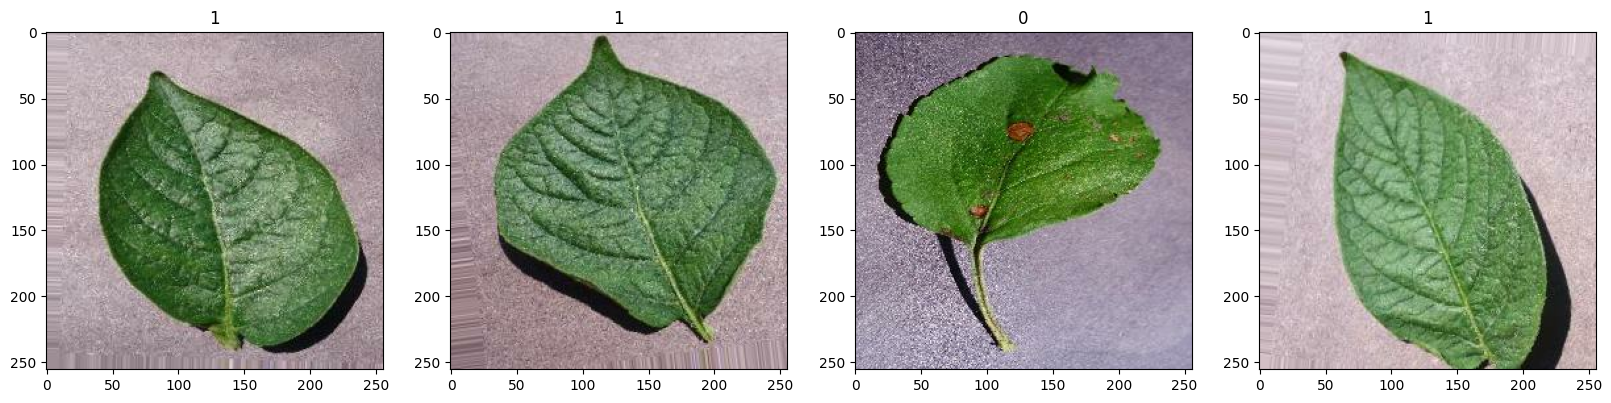

In [152]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [153]:
data = data.map(lambda x,y: (x/255, y))

In [135]:
data.as_numpy_iterator().next()

(array([[[[0.61960787, 0.56078434, 0.5882353 ],
          [0.60784316, 0.54901963, 0.5764706 ],
          [0.6156863 , 0.5568628 , 0.58431375],
          ...,
          [0.6901961 , 0.6313726 , 0.65882355],
          [0.6901961 , 0.6313726 , 0.65882355],
          [0.6901961 , 0.6313726 , 0.65882355]],
 
         [[0.61960787, 0.56078434, 0.5882353 ],
          [0.60784316, 0.54901963, 0.5764706 ],
          [0.6156863 , 0.5568628 , 0.58431375],
          ...,
          [0.6901961 , 0.6313726 , 0.65882355],
          [0.6901961 , 0.6313726 , 0.65882355],
          [0.6901961 , 0.6313726 , 0.65882355]],
 
         [[0.627451  , 0.5686275 , 0.59607846],
          [0.6039216 , 0.54509807, 0.57254905],
          [0.60784316, 0.54901963, 0.5764706 ],
          ...,
          [0.6745098 , 0.6156863 , 0.6431373 ],
          [0.6745098 , 0.6156863 , 0.6431373 ],
          [0.67058825, 0.6117647 , 0.6392157 ]],
 
         ...,
 
         [[0.6862745 , 0.6431373 , 0.6745098 ],
          [0.56078

# 5. Split Data

In [154]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [155]:
train_size

10

In [156]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [157]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [159]:
model = Sequential()

In [160]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [161]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [162]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [163]:
logdir='logs'

In [164]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [165]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
10/10 [==============================] - 12s 919ms/step - loss: 0.4817 - accuracy: 0.7531 - val_loss: 0.1626 - val_accuracy: 0.9375
Epoch 2/20
10/10 [==============================] - 7s 708ms/step - loss: 0.4589 - accuracy: 0.8188 - val_loss: 0.2062 - val_accuracy: 0.9479
Epoch 3/20
10/10 [==============================] - 7s 644ms/step - loss: 0.2514 - accuracy: 0.9094 - val_loss: 0.1737 - val_accuracy: 0.9479
Epoch 4/20
10/10 [==============================] - 6s 612ms/step - loss: 0.1606 - accuracy: 0.9469 - val_loss: 0.1295 - val_accuracy: 0.9688
Epoch 5/20
10/10 [==============================] - 7s 645ms/step - loss: 0.1028 - accuracy: 0.9688 - val_loss: 0.0489 - val_accuracy: 0.9896
Epoch 6/20
10/10 [==============================] - 7s 659ms/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.0232 - val_accuracy: 0.9896
Epoch 7/20
10/10 [==============================] - 7s 688ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch

# 8. Plot Performance

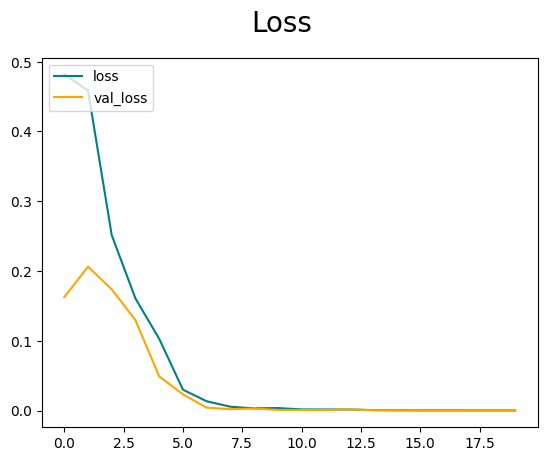

In [166]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

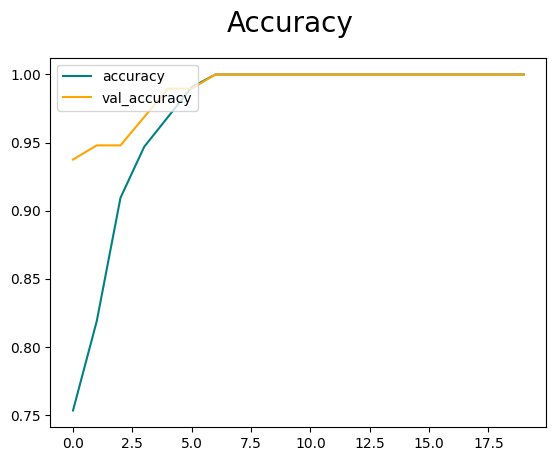

In [167]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [168]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [169]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [170]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 219ms/step


In [171]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [34]:
import cv2

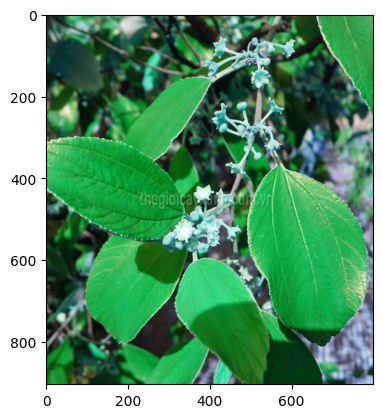

In [201]:
# img = cv2.imread('cuoi5.jpg')
img = cv2.imread('latao4.jpg')
plt.imshow(img)
plt.show()

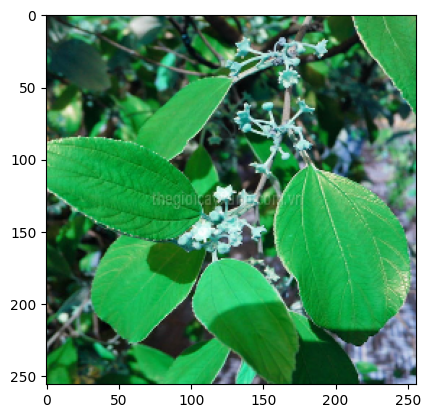

In [202]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [203]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 42ms/step


In [204]:
yhat

array([[0.26311654]], dtype=float32)

In [205]:
if yhat > 0.5: 
    # print(f'Predicted class is Sad')
    print("lá khoai tây")
else:
    # print(f'Predicted class is Happy')
    print("lá táo")

lá táo


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)